


# Transfer Learning
In this notebook, you will perform transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.



In [1]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"


/bin/bash: /home/sharoon/miniconda3/envs/tf112/lib/libtinfo.so.6: no version information available (required by /bin/bash)
2022-08-03 07:25:04.232810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 07:25:04.236966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 07:25:04.237284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Imports

In [2]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.1


In [3]:
!nvidia-smi

/bin/bash: /home/sharoon/miniconda3/envs/tf112/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Wed Aug  3 07:25:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA T600         Off  | 00000000:0A:00.0  On |                  N/A |
|100%   47C    P0    N/A /  41W |    483MiB /  3903MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------

## Parameters

- Define the batch size
- Define the class (category) names

In [4]:
BATCH_SIZE = 16
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Define some functions that will help you to create some visualizations. (These will be used later)

In [5]:
#@title Visualization Utilities[RUN ME]
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Loading and Preprocessing Data
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes. You will load the dataset from Keras.

In [6]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

### Visualize Dataset

Use the `display_image` to view some of the images and their class labels.

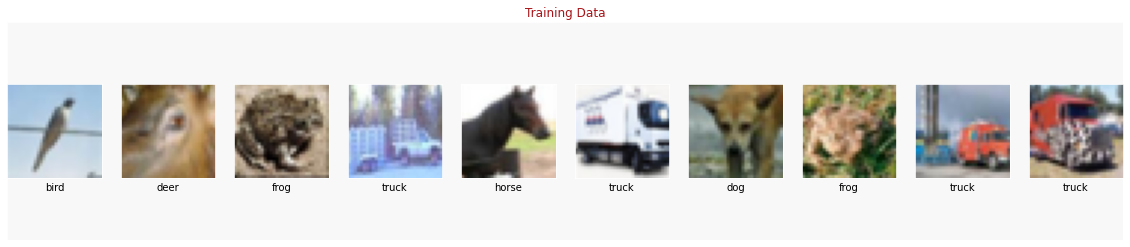

In [7]:
display_images(training_images, training_labels, training_labels, "Training Data" )

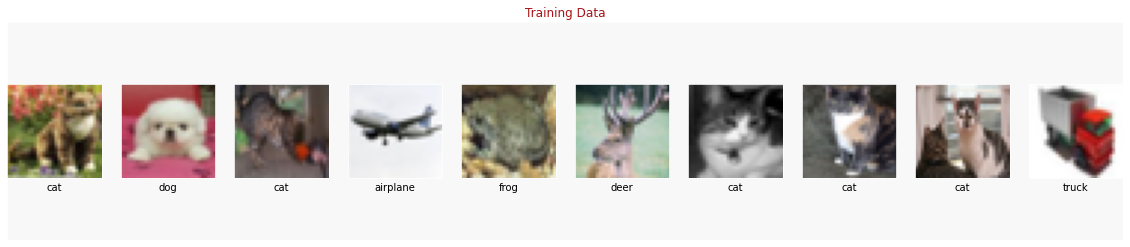

In [8]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [9]:
validation_images[0].astype('float32').shape

(32, 32, 3)

### Preprocess Dataset
Here, you'll perform normalization on images in training and validation set. 
- You'll use the function [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) from the ResNet50 model in Keras.

In [10]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [11]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Define the Network
You will be performing transfer learning on **ResNet50** available in Keras.
- You'll load pre-trained **imagenet weights** to the model.
- You'll choose to retain all layers of **ResNet50** along with the final classification layers.

In [12]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification", dtype = tf.float32)(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

2022-08-03 07:25:08.289370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 07:25:08.292792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 07:25:08.293100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 07:25:08.293619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               104908

## Train the model

In [13]:
# this will take around 20 minutes to complete
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=16)

Epoch 1/4


2022-08-03 07:25:13.618806: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-03 07:25:14.024109: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-08-03 07:25:15.318262: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 602.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-03 07:25:15.318304: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 602.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but 

3125/3125 [==============================] - 1405s 448ms/step - loss: 0.3671 - accuracy: 0.8768 - val_loss: 0.1947 - val_accuracy: 0.9354
Epoch 2/4
3125/3125 [==============================] - 1373s 439ms/step - loss: 0.1259 - accuracy: 0.9574 - val_loss: 0.1700 - val_accuracy: 0.9447
Epoch 3/4
3125/3125 [==============================] - 1406s 450ms/step - loss: 0.0643 - accuracy: 0.9779 - val_loss: 0.1687 - val_accuracy: 0.9483
Epoch 4/4
3125/3125 [==============================] - 1408s 451ms/step - loss: 0.0413 - accuracy: 0.9856 - val_loss: 0.1890 - val_accuracy: 0.9477


## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [14]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=16)

625/625 [==============================] - 77s 124ms/step - loss: 0.1890 - accuracy: 0.9477


### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

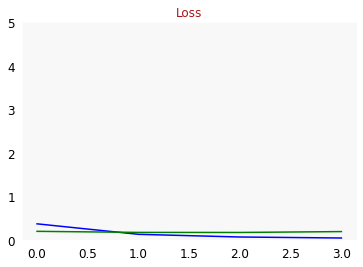

In [15]:
plot_metrics("loss", "Loss")

Plot the training accuracy (blue) as well as the validation accuracy (green).

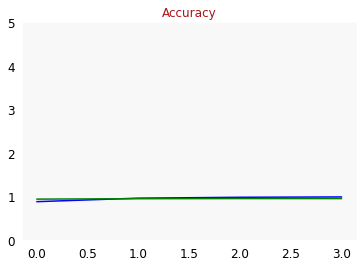

In [16]:
plot_metrics("accuracy", "Accuracy")

### Visualize predictions
You can take a look at the predictions on the validation set.

625/625 [==============================] - 78s 124ms/step


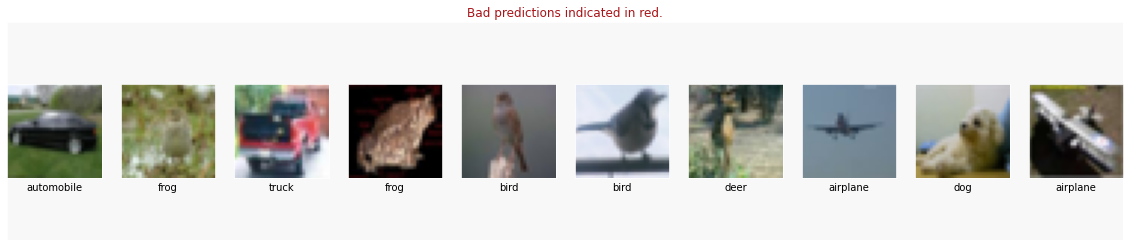

In [17]:
probabilities = model.predict(valid_X, batch_size=16)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")